# Seq2Seq Manipuri Transliteration


## 0. Extract data

In [8]:
from pathlib import Path

def pre_data():
    src = Path("raw/transcribed.txt")
    sep = "\t"
    bn_i = 0
    mm_i = 1  # try 2 for v2
    new_lines = [
        f"{line.split(sep)[bn_i]}\t{line.split(sep)[mm_i]}"
        for line in src.read_text(encoding="utf-8").strip().split("\n")
    ]

    Path("data/transcribed.txt").write_text("\n".join(new_lines), encoding="utf-8")
    
Path("data").mkdir(exist_ok=True)
pre_data()

## 1. Start

In [1]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from jiwer import wer, cer



 Load data

In [2]:
def load_data(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        lines = f.readlines()
    pairs = [line.strip().split() for line in lines if len(line.strip().split()) == 2]
    x_data, y_data = zip(*pairs)
    return list(x_data), list(y_data)

## 2. Tokenizer

 `CharTokenizer` maps characters to indices and vice versa.

In [3]:
class CharTokenizer:
    def __init__(self, vocab):
        self.char2idx = {ch: i + 1 for i, ch in enumerate(vocab)}
        self.char2idx["<pad>"] = 0
        self.char2idx["<sos>"] = len(self.char2idx)
        self.char2idx["<eos>"] = len(self.char2idx)
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, text, max_len):
        tokens = (
            [self.char2idx["<sos>"]]
            + [self.char2idx[ch] for ch in text if ch in self.char2idx]
            + [self.char2idx["<eos>"]]
        )
        tokens += [self.char2idx["<pad>"]] * (max_len - len(tokens))
        return tokens[:max_len]

    def decode(self, indices):
        return "".join(
            self.idx2char[idx]
            for idx in indices
            if idx in self.idx2char
            and idx not in [0, self.char2idx["<sos>"], self.char2idx["<eos>"]]
        )

## 3. TransliterationDataset

- `TransliterationDataset` converts word pairs into indexed sequences with padding.


In [4]:
class TransliterationDataset(Dataset):
    def __init__(self, x, y, x_tokenizer, y_tokenizer, max_len) -> None:
        self.x = x
        self.y = y
        self.x_tokenizer = x_tokenizer
        self.y_tokenizer = y_tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx):
        x_encoded = self.x_tokenizer.encode(self.x[idx], self.max_len)
        y_encoded = self.y_tokenizer.encode(self.y[idx], self.max_len)
        return torch.tensor(x_encoded, dtype=torch.long), torch.tensor(
            y_encoded, dtype=torch.long
        )

## 4. Model

- An **Encoder** using an LSTM.
- A **Decoder** with an attention mechanism.
- A **Seq2Seq** wrapper to combine them.

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(
            embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.shape[1]
        hidden = hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)
        combined = torch.cat([hidden, encoder_outputs], dim=2)
        energy = torch.tanh(self.attn(combined))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(
        self, output_dim, embed_dim, hidden_dim, num_layers, dropout, attention
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=output_dim, embedding_dim=embed_dim
        )
        self.rnn = nn.LSTM(
            input_size=embed_dim + hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(in_features=hidden_dim * 2, out_features=output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = attention

    def forward(self, inp, hidden, cell, encoder_outputs) -> torch.Tensor:
        inp = inp.unsqueeze(1)
        embedded = self.dropout(self.embedding(inp))
        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(
            torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)
        )
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        batch_size = y.shape[0]
        y_len = y.shape[1]
        y_vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, y_len, y_vocab_size).to(self.device)
        hidden, cell = self.encoder(x)
        inp = y[:, 0]
        encoder_outputs = hidden[-1].unsqueeze(1).repeat(1, x.shape[1], 1)

        for t in range(1, y_len):
            output, hidden, cell = self.decoder(inp, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            inp = (
                y[:, t] if torch.rand(1).item() < teacher_forcing_ratio else best_guess
            )

        return outputs

## 5. Train

In [6]:
# Load and Process Data
x_data, y_data = load_data("data/transcribed.txt")
x_vocab = set("".join(x_data))
y_vocab = set("".join(y_data))
MAX_LEN = max(max(map(len, x_data)), max(map(len, y_data))) + 2

# Extract model hyperparameters from data
EMBED_DIM = len(x_vocab) // 2
HIDDEN_DIM = max(len(x_vocab), len(y_vocab))
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = min(32, len(x_data) // 10)
LEARNING_RATE = 0.001
EPOCHS = 100

# Experiment Directory
EXP_DIR = "exp"
os.makedirs(EXP_DIR, exist_ok=True)

x_tokenizer = CharTokenizer(x_vocab)
y_tokenizer = CharTokenizer(y_vocab)

dataset = TransliterationDataset(x_data, y_data, x_tokenizer, y_tokenizer, MAX_LEN)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training Setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention = Attention(HIDDEN_DIM).to(DEVICE)
encoder = Encoder(
    len(x_tokenizer.char2idx), EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT
).to(DEVICE)
decoder = Decoder(
    len(y_tokenizer.char2idx), EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT, attention
).to(DEVICE)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


# Print Model Summary
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

# DataLoader Information
print(f'Batch size: {BATCH_SIZE}')
print(f'Total training samples: {len(x_data)}')
print(f'Training steps per epoch: {len(x_data) // BATCH_SIZE}')

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(64, 30)
    (rnn): LSTM(30, 61, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(50, 30)
    (rnn): LSTM(91, 61, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=122, out_features=50, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=122, out_features=61, bias=True)
      (v): Linear(in_features=61, out_features=1, bias=False)
    )
  )
)
Total trainable parameters: 137914
Batch size: 32
Total training samples: 58794
Training steps per epoch: 1837


### Training Loop

Epoch 1, Loss: 1707.5555
Epoch 2, Loss: 1449.6792
Epoch 3, Loss: 1276.4404
Epoch 4, Loss: 1094.5011
Epoch 5, Loss: 940.8567
Epoch 6, Loss: 800.0734
Epoch 7, Loss: 696.5797
Epoch 8, Loss: 621.8748
Epoch 9, Loss: 560.0332
Epoch 10, Loss: 513.4136
Epoch 11, Loss: 474.8169
Epoch 12, Loss: 439.8923
Epoch 13, Loss: 411.5627
Epoch 14, Loss: 386.6681
Epoch 15, Loss: 367.3283
Epoch 16, Loss: 350.1627
Epoch 17, Loss: 332.6881
Epoch 18, Loss: 316.9358
Epoch 19, Loss: 303.9773
Epoch 20, Loss: 295.0407
Epoch 21, Loss: 282.4068
Epoch 22, Loss: 273.7181
Epoch 23, Loss: 264.6263
Epoch 24, Loss: 257.0572
Epoch 25, Loss: 248.3644
Epoch 26, Loss: 241.5303
Epoch 27, Loss: 234.0157
Epoch 28, Loss: 229.2452
Epoch 29, Loss: 223.0054
Epoch 30, Loss: 216.4614
Epoch 31, Loss: 212.7794
Epoch 32, Loss: 210.2487
Epoch 33, Loss: 203.9861
Epoch 34, Loss: 200.3763
Epoch 35, Loss: 195.2267
Epoch 36, Loss: 192.4784
Epoch 37, Loss: 188.0237
Epoch 38, Loss: 185.4870
Epoch 39, Loss: 183.5461
Epoch 40, Loss: 179.0156
Epoch

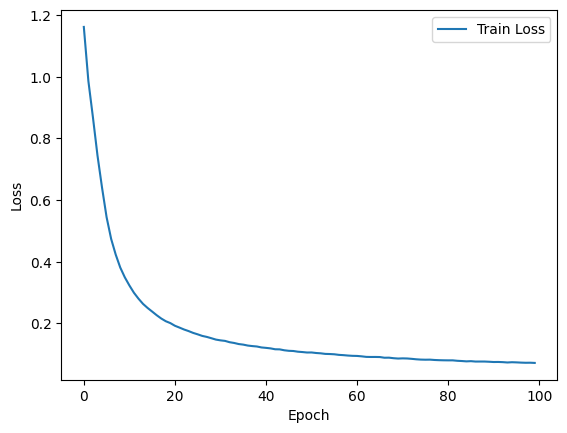

In [7]:
train_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x, y)
        loss = criterion(output[:, 1:].reshape(-1, output.shape[2]), y[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_dataloader))
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')
    
    # Save model every 10th epoch
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"{EXP_DIR}/model_epoch_{epoch}.pth")

# Plot Training Loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Eval

In [10]:
from jiwer import wer, cer
from pathlib import Path

model.eval()
preds, trues, inputs = [], [], []

SCORES_DIR = Path("exp/scores")
SCORES_DIR.mkdir(parents=True, exist_ok=True)
score_file = SCORES_DIR / "predictions.tsv"

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(DEVICE)
        output = model(x, y.to(DEVICE), teacher_forcing_ratio=0.0)
        output_ids = output.argmax(2).cpu().numpy()

        for i in range(x.shape[0]):
            input_str = x_tokenizer.decode(x[i].cpu().numpy())
            pred = y_tokenizer.decode(output_ids[i])
            true = y_tokenizer.decode(y[i].cpu().numpy())

            inputs.append(input_str)
            preds.append(pred)
            trues.append(true)

# Write scores to TSV
with score_file.open("w", encoding="utf-8") as f:
    f.write("Input\tTarget\tPredicted\tCER\n")
    for inp, tgt, prd in zip(inputs, trues, preds):
        f.write(f"{inp}\t{tgt}\t{prd}\t{cer([tgt], [prd]):.4f}\n")

# Print final metrics
print(f"Test WER: {wer(trues, preds):.4f}")
print(f"Test CER: {cer(trues, preds):.4f}")


Test WER: 0.1282
Test CER: 0.0289
